In [1]:
#Name: Sirinian Aram Emmanouil
#AM: 2537
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from datetime import datetime
from collections import Counter
import json
import time
import random
import scipy.sparse as sp_sparse
import sklearn.metrics.pairwise as cossim
import heapq
import math
from operator import itemgetter
%matplotlib inline

In [2]:
def UpdateBusinessCount(business_id):
    business_data[business_id] +=1

def UpdateUserCount(user_id):
    user_data[user_id] +=1

In [3]:
user_data = {}
business_data = {}
review_data = []
tempArray = []
flag = True
old_len_of_review_data = 99999999
new_len_of_review_data = 0
user_data_g9 = set()
business_data_g9 = set()

while( (old_len_of_review_data - new_len_of_review_data) > 0 ):
    if(flag):   
        with open('business.json') as f:
            for line in f:
                try:
                    if(json.loads(line.strip())["city"] == "Toronto"):
                        business_data[(json.loads(line.strip())["business_id"])] = 0
                except ValueError:
                    pass

        with open('review.json') as f:
            for line in f:
                try:
                    x = json.loads(line.strip())
                    if((x["user_id"]) in user_data):
                        UpdateUserCount(x["user_id"])
                    if((x["user_id"]) not in user_data):
                        user_data[(x["user_id"])] = 1
                    if((x["business_id"]) in business_data):
                        UpdateBusinessCount(x["business_id"])
                    review_data.append((x["user_id"], x["business_id"], x["stars"]))
                except ValueError:
                    pass

        flag = False
    else:
        tempArray = []
        for x in review_data:
            tempArray.append(x[0])
        tempArray = set(tempArray)
        for x in tempArray:
            user_data[x] = 0

        tempArray = []
        for x in review_data:
            tempArray.append(x[1])
        tempArray = set(tempArray)
        for x in tempArray:
            business_data[x] = 0

        for x in review_data:
            if((x[0]) in user_data):
                UpdateUserCount(x[0])
            if((x[1]) in business_data):
                UpdateBusinessCount(x[1])

    old_len_of_review_data = len(review_data)

    tempArray = []
    for key, value in user_data.items():
        if(value>9):
            tempArray.append(key)
    user_data_g9 = set(tempArray)

    tempArray = []
    for key, value in business_data.items():
        if(value>9):
            tempArray.append(key)
    business_data_g9 = set(tempArray)

    tempArray = []
    for x in review_data:
        if( (x[0] in user_data_g9) and (x[1] in business_data_g9) ):
            tempArray.append((x[0], x[1], x[2]))
    review_data = tempArray

    new_len_of_review_data = len(review_data)

In [4]:
###################### Remove random 10% #############################
number_of_ratings = len(review_data)
ps10 = (int) (abs( (number_of_ratings * 10) / 100 ))
random_ps10 = []

for i in range(ps10):
    number_of_ratings = len(review_data)
    random_ps10.append( review_data.pop( random.choice(range(number_of_ratings + 1)) ) )

In [5]:
######################################################################
tempArray = []
tempArray2 = []
review_data2_dict = {}
for x in review_data:
    tempArray.append(x[0])
    tempArray2.append(x[1])
user_data_g9 = set(tempArray)
business_data_g9 = set(tempArray2)
tempArray = []
tempArray2 = []
user_data_g9 = list(user_data_g9)
business_data_g9 = list(business_data_g9)

review_data2 = [list(x) for x in review_data]
for x in review_data2:
    x[0] = user_data_g9.index(x[0])
    x[1] = business_data_g9.index(x[1])
    review_data2_dict[x[0], x[1]] = x[2]

In [6]:
row = [] # user_data_g9
col = [] # business_data_g9
data = [] # ratings

for x in review_data2:
    row.append(x[0])
    col.append(x[1])
    data.append(x[2])

In [7]:
M = sp_sparse.csr_matrix((data,(row,col)))
M = sp_sparse.lil_matrix(M)

In [8]:
####### User Average (UA) & Business Average (BA) ########
(x,y,z) = sp_sparse.find(M)
countings = np.bincount(x)
sums=np.bincount(x,weights=z)
averages_of_M = sums/countings

(x,y,z) = sp_sparse.find(M.T)
countings = np.bincount(x)
sums=np.bincount(x,weights=z)
averages_of_MT = sums/countings

def getUA(user):
    return averages_of_M[user_data_g9.index(user)]

def getBA(business):
    return averages_of_MT[business_data_g9.index(business)]

In [9]:
##### 4. User-based Collaborative Filtering (UCF) #####

def normalizedCosineSimilarity(array1, array2):
    tempArray = [array1, array2]
    tempM = sp_sparse.lil_matrix(tempArray)
    tempM = tempM[:,:] * 0.1
    
    (x,y,z) = sp_sparse.find(tempM)
    countings = np.bincount(x)
    sums=np.bincount(x,weights=z)
    averages_of_tempM = sums/countings
    
    for i in range(tempM.shape[0]):
        for j in range(tempM.shape[1]):
            if(tempM[i,j]>0):
                tempM[i,j] = tempM[i,j] - averages_of_tempM[i]
    
    if(cossim.cosine_similarity(tempM)[0,1] < 1):
        return 1
    elif(cossim.cosine_similarity(tempM)[0,1] > 5):
        return 5
    else:
        return cossim.cosine_similarity(tempM)[0,1]

In [10]:
def mostSimilarUsers(user, business, k):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    temp_similarity_dict = {}
    
    tempArray = []
    tempArray2 = []
    tempArray2 = M.T[business_id].toarray().tolist()[0]
    for i in range(len(tempArray2)):
        if(tempArray2[i] > 0):
            tempArray.append(i)
    
    for i in tempArray:
        temp_normalized_cosine_similarity = normalizedCosineSimilarity(M[user_id].toarray().tolist()[0], M[i].toarray().tolist()[0])
        temp_similarity_dict[i] = temp_normalized_cosine_similarity
    k_top_items = heapq.nlargest(n=k, iterable=temp_similarity_dict.items(), key=itemgetter(1))
    return dict(k_top_items)

In [11]:
def equationUCF(user, business, k):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    user_mean = getUA(user)
    p = user_mean
    temp_numerator = 0
    temp_denominator = 0
    most_similar_users = mostSimilarUsers(user, business, k)
    most_similar_users_keys = list(most_similar_users.keys())
    
    range_of_most_similar_users = len(most_similar_users_keys)
    
    for i in range(range_of_most_similar_users):
        similarity_user_user2 = 0
        user2_rating = 0
        user2_mean = 0
        #####
        similarity_user_user2 = most_similar_users[most_similar_users_keys[i]]

        user2_rating = review_data2_dict[(most_similar_users_keys[i], business_id)]
        
        user2_mean = getUA(user_data_g9[most_similar_users_keys[i]])
        #####
        temp_numerator += similarity_user_user2 * (user2_rating - user2_mean)
        temp_denominator += similarity_user_user2
    
    p += ( temp_numerator / temp_denominator )
    return p

In [12]:
##### 4. Item-based Collaborative Filtering (ΙCF) #####

def cosineSimilarity(array1, array2):
    tempArray = [array1, array2]
    return cossim.cosine_similarity(tempArray)[0,1]

In [13]:
def mostSimilarBusinesses(user, business, k):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    temp_similarity_dict = {}
    
    tempArray = []
    tempArray2 = []
    tempArray2 = M[user_id].toarray().tolist()[0]
    for i in range(len(tempArray2)):
        if(tempArray2[i] > 0):
            tempArray.append(i)
    
    for i in tempArray:
        temp_cosine_similarity = cosineSimilarity(M.T[business_id].toarray().tolist()[0], M.T[i].toarray().tolist()[0])### Find something faster for this one
        temp_similarity_dict[i] = temp_cosine_similarity
    k_top_items = heapq.nlargest(n=k, iterable=temp_similarity_dict.items(), key=itemgetter(1))
    return dict(k_top_items)

In [14]:
def equationICF(user, business, k):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    p = 0
    temp_numerator = 0
    temp_denominator = 0
    most_similar_businesses = mostSimilarBusinesses(user, business, k)
    most_similar_businesses_keys = list(most_similar_businesses.keys())
    
    range_of_most_similar_businesses = len(most_similar_businesses_keys)
    
    for i in range(range_of_most_similar_businesses):
        similarity_business_business2 = 0
        business2_rating = 0
        
        similarity_business_business2 = most_similar_businesses[most_similar_businesses_keys[i]]

        business2_rating = review_data2_dict[(user_id, most_similar_businesses_keys[i])]
        
        temp_numerator += similarity_business_business2 * business2_rating
        temp_denominator += similarity_business_business2
        
    p += ( temp_numerator / temp_denominator )
    return p

In [15]:
####### 5. Singular Value Decomposition (SVD) #######
LA = np.linalg
tempArray = np.array(M.toarray().tolist())
U, s, Vh = LA.svd(tempArray, full_matrices=False)

def plotSfromMatrixSVD():
    plt.figure(figsize=(12,8))
    plt.plot(s[:])
    plt.ylabel('eigenvalue value')
    plt.xlabel('number of eigenvalues')

def matrixSVD(k):
    s[k:] = 0
    new_tempArray = np.dot(U, np.dot(np.diag(s), Vh))
    return new_tempArray   

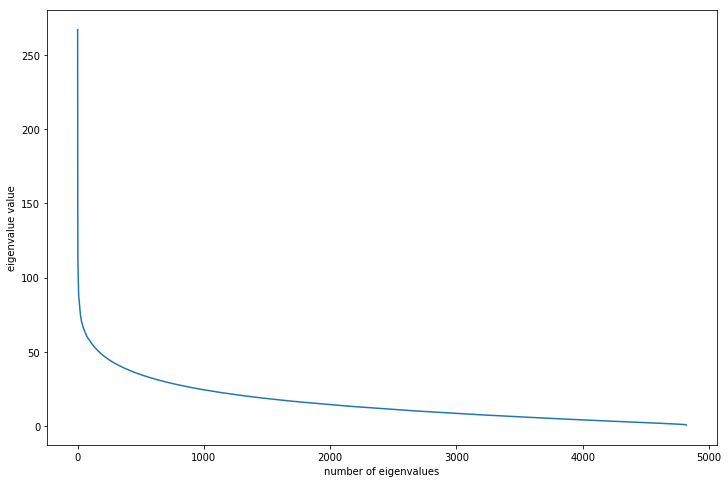

In [16]:
plotSfromMatrixSVD()#best results when k=2 or somewhere (0,1000)

In [17]:
matrix_svd = []
def setMatrixSVD(k):
    return matrixSVD(k)

In [18]:
def equationSVD(user, business):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    
    return matrix_svd[user_id][business_id]

In [19]:
################## (Root Mean Square Error) #################################

In [20]:
number_of_ratings = 10
number_of_k_values = 9
k_values = []

for i in range(number_of_k_values):
    k_values.append(int(round(np.exp(i))))

In [21]:
sample_info = []
random_ps10_UCF = []
random_ps10_ICF = []

for i in range(number_of_ratings):
    random_ps10_id = random.choice(range(len(random_ps10) + 1))
    sample_info.append(random_ps10_id)

for i in range(number_of_ratings):
    temp_random_ps10_UCF = []
    temp_random_ps10_ICF = []
    for j in range(number_of_k_values):
        k_value_aka_rounded_exp = k_values[j]
        temp_random_ps10_UCF.append(equationUCF(random_ps10[sample_info[i]][0], random_ps10[sample_info[i]][1], k_value_aka_rounded_exp))
        temp_random_ps10_ICF.append(equationICF(random_ps10[sample_info[i]][0], random_ps10[sample_info[i]][1], k_value_aka_rounded_exp))
    random_ps10_UCF.append(temp_random_ps10_UCF)
    random_ps10_ICF.append(temp_random_ps10_ICF)

In [22]:
random_ps10_UA = []
random_ps10_BA = []

for i in range(number_of_ratings):
    temp_random_ps10_UA = []
    temp_random_ps10_BA = []
    for j in range(number_of_k_values):
        temp_random_ps10_UA.append(getUA(random_ps10[sample_info[i]][0]))
        temp_random_ps10_BA.append(getBA(random_ps10[sample_info[i]][1]))
    random_ps10_UA.append(temp_random_ps10_UA)
    random_ps10_BA.append(temp_random_ps10_BA)

In [23]:
random_ps10_SVD = []

for i in range(number_of_ratings):
    temp_random_ps10_SVD = []
    for j in range(number_of_k_values):
        temp_random_ps10_SVD2 = []
        temp_random_ps10_SVD.append(temp_random_ps10_SVD2)
    random_ps10_SVD.append(temp_random_ps10_SVD)

In [24]:
for i in range(number_of_k_values):
    k_value_aka_rounded_exp = k_values[i]
    matrix_svd = setMatrixSVD(k_value_aka_rounded_exp)
    for j in range(number_of_ratings):
        random_ps10_SVD[j][i].append(equationSVD(random_ps10[sample_info[j]][0], random_ps10[sample_info[j]][1]))

In [25]:
array_p = []

for i in sample_info:
    array_p.append(random_ps10[i][2])

In [26]:
array_r_UCF = []

for i in range(number_of_k_values):
    temp_array_r_UCF = []
    for j in range(number_of_ratings):
        temp_array_r_UCF.append(random_ps10_UCF[j][i])
    array_r_UCF.append(temp_array_r_UCF)

In [27]:
array_r_ICF = []

for i in range(number_of_k_values):
    temp_array_r_ICF = []
    for j in range(number_of_ratings):
        temp_array_r_ICF.append(random_ps10_ICF[j][i])
    array_r_ICF.append(temp_array_r_ICF)

In [28]:
array_r_UA = []
array_r_BA = []

for i in range(number_of_k_values):
    temp_array_r_UA = []
    temp_array_r_BA = []
    for j in range(number_of_ratings):
        temp_array_r_UA.append(random_ps10_UA[j][i])
        temp_array_r_BA.append(random_ps10_BA[j][i])
    array_r_UA.append(temp_array_r_UA)
    array_r_BA.append(temp_array_r_BA)

In [29]:
array_r_SVD = []

for i in range(number_of_k_values):
    temp_array_r_SVD = []
    for j in range(number_of_ratings):
        temp_array_r_SVD.append(random_ps10_SVD[j][i][0])
    array_r_SVD.append(temp_array_r_SVD)

In [30]:
def calculateRMSE(array_r, array_p):
    n = len(array_r)
    temp_sum = 0
    for i in range(n):
        temp_sub = array_r[i] - array_p[i]
        temp_sum += pow(temp_sub, 2)
    return math.sqrt(temp_sum/n)### TODO test it

In [31]:
array_r_UCF_RMSE = []
array_r_ICF_RMSE = []
array_r_UA_RMSE = []
array_r_BA_RMSE = []
array_r_SVD_RMSE = []


for i in range(number_of_k_values):
    array_r_UCF_RMSE.append( calculateRMSE(array_r_UCF[i], array_p) )
    array_r_ICF_RMSE.append( calculateRMSE(array_r_ICF[i], array_p) )
    array_r_UA_RMSE.append( calculateRMSE(array_r_UA[i], array_p) )
    array_r_BA_RMSE.append( calculateRMSE(array_r_BA[i], array_p) )
    array_r_SVD_RMSE.append( calculateRMSE(array_r_SVD[i], array_p) )

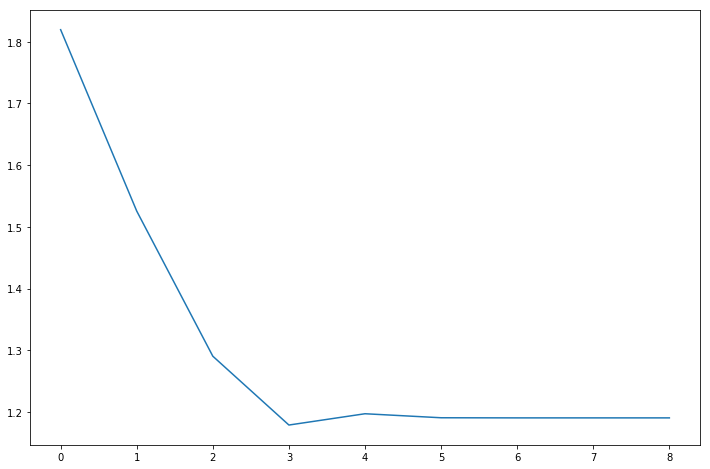

In [32]:
plt.figure(figsize=(12,8))
plt.plot(array_r_UCF_RMSE[:])

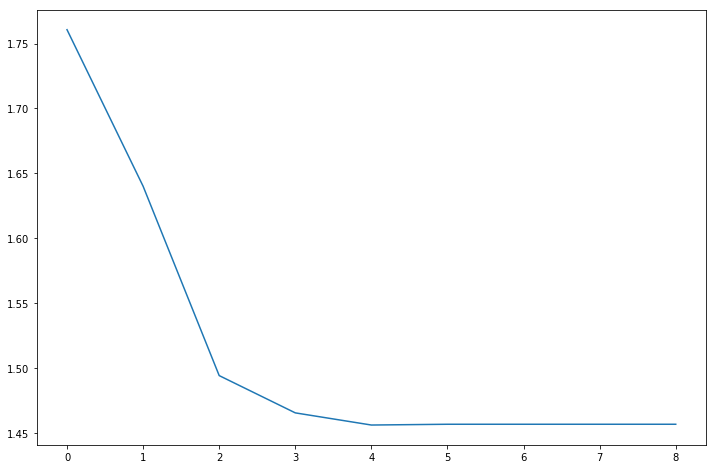

In [33]:
plt.figure(figsize=(12,8))
plt.plot(array_r_ICF_RMSE[:])

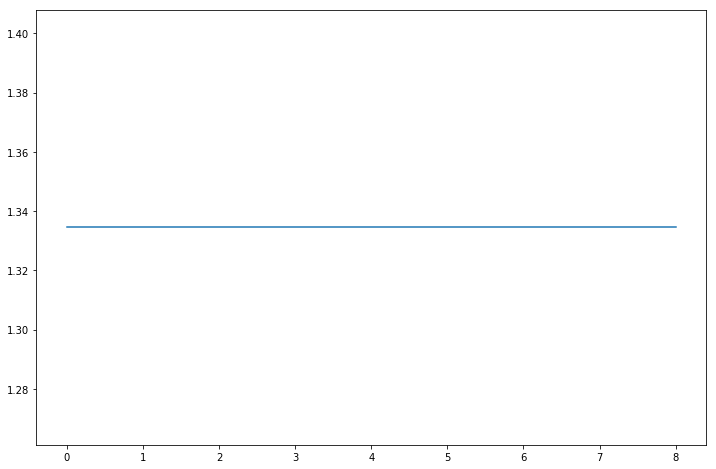

In [34]:
plt.figure(figsize=(12,8))
plt.plot(array_r_UA_RMSE[:])

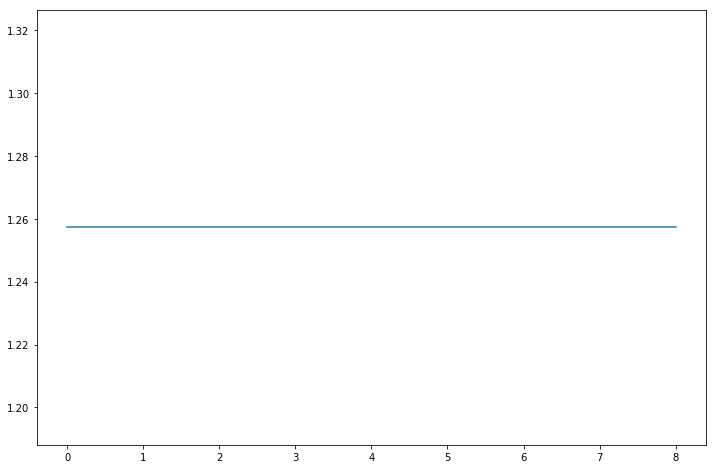

In [35]:
plt.figure(figsize=(12,8))
plt.plot(array_r_BA_RMSE[:])

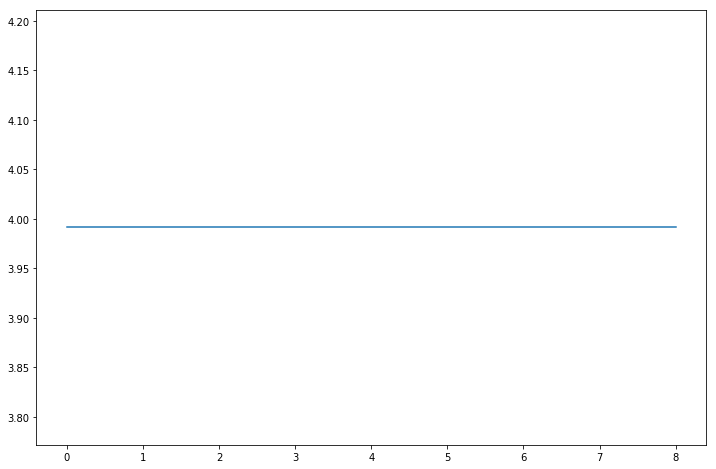

In [36]:
plt.figure(figsize=(12,8))
plt.plot(array_r_SVD_RMSE[:])